### **Integrantes:**
* Henry Tacuri
* Franklin Guapisaca
* Juan Quizhpi

In [ ]:
!pip install nrclex scikit-learn torch transformers seaborn
!pip uninstall emoji -y
!pip install emoji==0.6.0

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

<div style="color: black; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Preparación de Datos</h1> </div>

### **Importación de librerías**

In [ ]:
import transformers
import nltk
nltk.download('punkt_tab')

import pandas as pd
import numpy as np
import ast
from nrclex import NRCLex
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns
import os

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### **Carga y preparación del dataset de comentarios lematizados para análisis por enfermedad**

In [ ]:
# Carga del dataset (ajusta la ruta según tu entorno)
df = pd.read_csv('/content/dataset_limpio_general.csv', encoding='utf-8-sig')

# Solo nos quedamos con 'lemma_comment' y 'enfermedad'
df = df[['lemma_comment', 'enfermedad']].copy()

# Convierte string a lista y luego a texto
df['lemma_comment'] = df['lemma_comment'].apply(ast.literal_eval)
df['text'] = df['lemma_comment'].apply(lambda x: " ".join(x).strip())
df = df[df['text'].str.strip() != ""]
df = df.dropna(subset=['text', 'enfermedad'])

df.head()


,lemma_comment,enfermedad,text
0,"[relampago, azul]",Cáncer cerebral,relampago azul
1,"[millie, santiago, rosario, abundante, bendici...",Cáncer cerebral,millie santiago rosario abundante bendición di...
2,"[ma, luz, valdovino, glorio]",Cáncer cerebral,ma luz valdovino glorio
3,"[edith, zamarripar]",Cáncer cerebral,edith zamarripar
4,"[lia, antonio, amen, amar, dio, poderoso]",Cáncer cerebral,lia antonio amen amar dio poderoso


### **Etiquetado de emociones en comentarios utilizando NRCLex**

Aqui se aplica la biblioteca NRCLex para analizar el contenido emocional de textos lematizados. A cada comentario se le asigna la emoción predominante según el léxico NRC. El resultado es una nueva columna emotion en el DataFrame, y se identifican 10 emociones distintas, incluyendo categorías como joy, fear, disgust, neutral, positive y negative. Esto permite realizar análisis posteriores basados en la carga emocional del texto.

In [ ]:
def etiqueta_emocion_nrc(texto):
    emo = NRCLex(texto)
    scores = emo.raw_emotion_scores
    if scores:
        return max(scores, key=scores.get)
    else:
        return "neutral"

print("Etiquetando emociones con NRCLex...")
df['emotion'] = df['text'].apply(etiqueta_emocion_nrc)
emotions = sorted(df['emotion'].unique())
print("Emociones encontradas:", emotions)


Etiquetando emociones con NRCLex...
Emociones encontradas: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'neutral', 'positive', 'surprise', 'trust']


Este fragmento de código prepara un conjunto de datos de texto etiquetado con emociones para entrenar un modelo de clasificación. Primero, extrae los textos (X) y las etiquetas emocionales (y), y luego filtra aquellas emociones que aparecen al menos dos veces para asegurar que haya suficientes ejemplos por clase. Luego, divide los datos en entrenamiento y prueba utilizando una división estratificada, asegurando que las proporciones de clases se mantengan. Los textos se vectorizan con TF–IDF y se entrena un clasificador Naive Bayes Multinomial. Finalmente, el modelo predice sobre el conjunto de prueba y se imprime un reporte de clasificación con métricas por emoción.

In [ ]:
X = df['text'].values
y = df['emotion'].values

# Cuenta las ocurrencias por emoción
emociones_conteo = pd.Series(y).value_counts()
emociones_validas = emociones_conteo[emociones_conteo >= 2].index.tolist()

# Filtra el DataFrame para quedarte solo con emociones con al menos 2 ejemplos
filtro = df['emotion'].isin(emociones_validas)
df_filtrado = df[filtro]
X = df_filtrado['text'].values
y = df_filtrado['emotion'].values


# División en train/test para comparación rápida
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
vect = TfidfVectorizer(max_features=10000)
Xtr = vect.fit_transform(X_train)
Xte = vect.transform(X_test)
nb = MultinomialNB()
nb.fit(Xtr, y_train)
pred_nb = nb.predict(Xte)

print("=== BASELINE: NB + TF–IDF ===")
print(classification_report(y_test, pred_nb, labels=emotions, digits=4))


=== BASELINE: NB + TF–IDF ===
              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000        22
anticipation     0.0000    0.0000    0.0000         5
     disgust     0.0000    0.0000    0.0000         7
        fear     0.0000    0.0000    0.0000         9
         joy     0.0000    0.0000    0.0000         5
    negative     0.0000    0.0000    0.0000        24
     neutral     0.7800    1.0000    0.8764       383
    positive     0.0000    0.0000    0.0000        32
    surprise     0.0000    0.0000    0.0000         0
       trust     0.0000    0.0000    0.0000         4

    accuracy                         0.7800       491
   macro avg     0.0780    0.1000    0.0876       491
weighted avg     0.6085    0.7800    0.6837       491



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

### **Conclusión de resultados**

El modelo muestra un desempeño muy pobre para casi todas las emociones excepto neutral, que domina el conjunto de datos y es la única clase correctamente identificada. Esto sugiere un desequilibrio severo en las clases, donde la mayoría de los ejemplos pertenecen a la clase neutral. Como resultado, el modelo aprende a predecir solo esta clase para maximizar su precisión, ignorando las emociones minoritarias. La precisión general (78%) es engañosa, ya que se debe únicamente al alto número de casos neutral, mientras que las emociones verdaderamente importantes no están siendo reconocidas.

<div style="color: black; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Entrenamiento y despliegue de un modelo BERT multilingüe para la clasificación de emociones en comentarios médicos</h1> </div>

### **Preparación y configuración del modelo BERT para clasificación de emociones**

Este fragmento de código prepara todo lo necesario para entrenar un modelo BERT multilingüe en una tarea de clasificación de emociones a partir de texto. Se carga un tokenizer preentrenado y se define una clase personalizada (EmocionDataset) que adapta los datos de entrada al formato requerido por BERT, incluyendo la tokenización y codificación de etiquetas. Luego, se realiza una división estratificada de los datos para entrenamiento y validación, y se instancian los conjuntos tokenizados. A continuación, se carga el modelo BertForSequenceClassification ajustado al número de emociones a predecir, se define una función para calcular métricas clave (precisión, recall y F1), y se configuran los argumentos de entrenamiento, incluyendo opciones como el tamaño del batch, número de épocas, y aprendizaje temprano (early stopping). Finalmente, se crea un objeto Trainer que encapsula el modelo, los datos y las métricas, dejándolo listo para iniciar el entrenamiento.

In [ ]:
# Carga del tokenizer de BERT multilingüe ya entrenado
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")

# Clase personalizada para el Dataset adaptado a BERT
class EmocionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, emotions, max_len=128):
        # Tokenización de los textos con padding/truncado y conversión a tensores
        self.enc = tokenizer(
            list(texts),
            padding="max_length",
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        )
        # Conversión de etiquetas de texto a índices numéricos
        self.labels = [emotions.index(l) for l in labels]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        # Recupera los datos tokenizados del índice i y añade la etiqueta correspondiente
        item = {k: v[i] for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[i])
        return item

# División estratificada de los datos en entrenamiento y validación (80/20)
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Creación de los datasets tokenizados para entrenamiento y validación
train_ds = EmocionDataset(X_temp, y_temp, tokenizer, emotions)
val_ds   = EmocionDataset(X_val, y_val, tokenizer, emotions)

# Carga del modelo preentrenado de BERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(emotions)  # Número de clases a predecir
)

# Función para calcular métricas de evaluación
def compute_metrics(pred):
    labels_ids = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    # Se calculan precisión, recall y F1 ponderadas por clase
    p, r, f1, _ = precision_recall_fscore_support(
        labels_ids, preds,
        labels=list(range(len(emotions))),
        average="weighted"
    )
    return {"precision": p, "recall": r, "f1": f1}

# Configuración de los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./bert_emociones/",        # Carpeta de salida del modelo entrenado
    eval_strategy="epoch",                 # Evaluar al final de cada época
    save_strategy="epoch",                 # Guardar modelo al final de cada época
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    load_best_model_at_end=True,           # Cargar el mejor modelo según métrica final
    metric_for_best_model="f1",            # Métrica clave para guardar el mejor modelo
    save_total_limit=2,                    # Guardar como máximo 2 checkpoints
    report_to="none"                       # No enviar métricas a servicios externos
)

# Inicialización del entrenador con modelo, datasets, métricas y early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Este fragmento continúa con el proceso de entrenamiento del modelo BERT previamente configurado. Primero, se llama al método train() del objeto Trainer, lo que inicia el entrenamiento del modelo durante 3 épocas usando los conjuntos de entrenamiento y validación definidos anteriormente. Luego, se define la función **predecir_emociones**, que permite aplicar el modelo entrenado a un nuevo conjunto de comentarios. Esta función procesa los datos nuevos, realiza la tokenización necesaria y utiliza el modelo para predecir la emoción predominante en cada comentario. Los resultados se agregan al DataFrame original en una nueva columna llamada **pred_emocion**.

In [ ]:
# Entrenamieto del modelo
trainer.train()

# Predicción en nuevo conjunto de comentarios
def predecir_emociones(comentarios_df, tokenizer, trainer, emotions):
    comentarios_df = comentarios_df.copy()
    comentarios_df['lemma_comment'] = comentarios_df['lemma_comment'].apply(ast.literal_eval)
    comentarios_df['text'] = comentarios_df['lemma_comment'].apply(lambda x: " ".join(x).strip())
    comentarios_df = comentarios_df[comentarios_df['text'].str.strip() != ""]
    test_ds = EmocionDataset(comentarios_df['text'].values, ["neutral"]*len(comentarios_df), tokenizer, emotions)
    pred = trainer.predict(test_ds)
    y_pred = np.argmax(pred.predictions, axis=1)
    comentarios_df['pred_emocion'] = [emotions[i] for i in y_pred]
    return comentarios_df

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.768164,0.685480,0.788187,0.730418
2,No log,0.539774,0.824331,0.867617,0.842173
3,0.777200,0.457217,0.836425,0.885947,0.859834


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

### **Conclusión de resultados**

El resultado del entrenamiento muestra una mejora progresiva en el rendimiento del modelo a lo largo de las 3 épocas. El valor de la pérdida de validación (Validation Loss) disminuye consistentemente, lo cual indica que el modelo está aprendiendo sin sobreajustarse. Asimismo, las métricas de evaluación —precisión, recall y F1— aumentan notablemente, alcanzando en la última época una precisión del 83.6%, un recall del 88.6% y un F1-score del 85.9%. Estos resultados sugieren que el modelo BERT multilingüe se ha ajustado de manera eficaz a la tarea de clasificación emocional sobre los datos proporcionados.

### **Visualización de la distribución emocional por tipo de enfermedad**

Este fragmento de código realiza la visualización de las emociones predominantes en comentarios relacionados con diferentes enfermedades. Primero, agrupa el DataFrame predicho por enfermedad y emoción, calculando la proporción de cada emoción dentro de cada grupo. Luego, utiliza un gráfico de barras horizontales apiladas para representar visualmente estas proporciones, aplicando una paleta de colores diferenciada por emoción. Esto permite analizar rápidamente cómo varían las emociones según la enfermedad mencionada en los comentarios.

In [ ]:
def graficar_distribucion_emociones(df_pred):
    # Agrupa por enfermedad y calcula la proporción de cada emoción dentro de cada grupo
    resumen = (
        df_pred.groupby("enfermedad")["pred_emocion"]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )

    # Diccionario que asigna un color a cada emoción para la gráfica
    colores = {
        "anger": "#e74c3c",
        "fear": "#8e44ad",
        "negative": "#34495e",
        "neutral": "#95a5a6",
        "positive": "#2ecc71",
        "surprise": "#f1c40f",
        "trust": "#3498db"
    }

    # Selecciona solo las columnas (emociones) que están en el diccionario de colores
    resumen = resumen[[col for col in colores.keys() if col in resumen.columns]]

    # Genera la gráfica de barras horizontales apiladas con los colores definidos
    resumen.plot(
        kind='barh',
        stacked=True,
        figsize=(10, 6),
        color=[colores.get(col, "#7f8c8d") for col in resumen.columns]
    )

    plt.title("Distribución de emociones por enfermedad", fontsize=14)
    plt.xlabel("Proporción")
    plt.ylabel("Enfermedad")
    plt.legend(title="Emoción", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


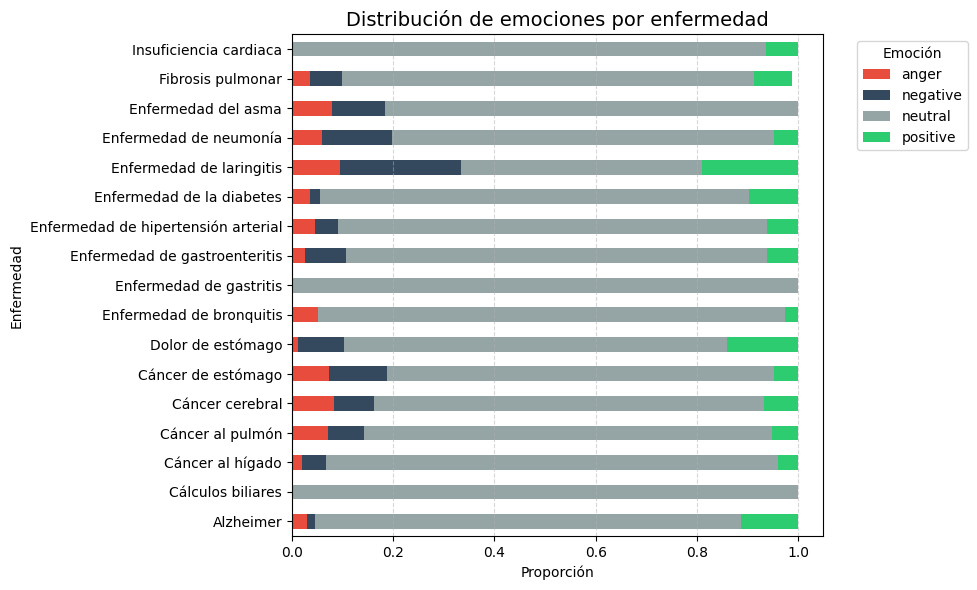

In [ ]:
df_nuevos_comentarios = pd.read_csv('/content/dataset_limpio_general.csv', encoding='utf-8-sig')

# Realiza la predicción de emociones en los nuevos comentarios utilizando la función predefinida
df_pred_nuevos = predecir_emociones(df_nuevos_comentarios, tokenizer, trainer, emotions)

# Grafica la distribución de emociones para las predicciones obtenidas
graficar_distribucion_emociones(df_pred_nuevos)

### **Conclusión de resultados**

El gráfico muestra que, en general, la emoción neutral domina en la mayoría de enfermedades, lo cual es común en textos informativos o descriptivos. Sin embargo, también se observa una presencia significativa de emociones negativas (como anger y negative) en enfermedades graves como el cáncer o fibrosis pulmonar. Emociones positivas también están presentes, aunque en menor proporción, y se distribuyen de forma más notoria en enfermedades tratables o de menor severidad como la laringitis o el dolor de estómago. En conjunto, la visualización proporciona una visión clara del impacto emocional percibido por los usuarios al referirse a cada enfermedad.

<div style="color: black; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Análisis emocional específico para la enfermedad</h1> </div>

Aqui se realiza un análisis de emociones centrado exclusivamente en los comentarios relacionados con una enfermedad en específico. Primero, filtra el dataset original para quedarse únicamente con esta enfermedad, luego utiliza el modelo entrenado para predecir las emociones asociadas a los comentarios filtrados. Posteriormente, se genera una gráfica de barras que muestra la proporción de cada emoción detectada. Se aplican colores personalizados por tipo de emoción, y se asegura que todas las categorías posibles estén representadas (aunque no estén presentes en los datos) para mantener coherencia visual entre gráficas.

In [ ]:
def graficar_una_enfermedad_barras(df_pred, nombre_enfermedad="Enfermedad"):
    resumen = (
        df_pred["pred_emocion"]
        .value_counts(normalize=True)
        .reindex(["anger", "fear", "negative", "neutral", "positive", "surprise", "trust"])
        .fillna(0)
    )
    colores = {
        "anger": "#e74c3c", "fear": "#8e44ad", "negative": "#34495e",
        "neutral": "#95a5a6", "positive": "#2ecc71", "surprise": "#f1c40f", "trust": "#3498db"
    }
    resumen.plot(
        kind="bar", color=[colores.get(e, "#7f8c8d") for e in resumen.index],
        figsize=(8, 4)
    )
    plt.title(f"Distribución de emociones en {nombre_enfermedad}", fontsize=14)
    plt.ylabel("Proporción")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


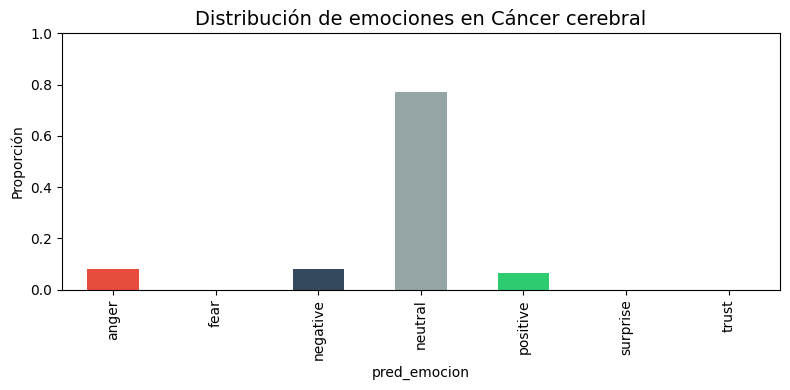

In [ ]:
df_nuevos_comentarios_enfermedad = pd.read_csv('/content/dataset_limpio_general.csv', encoding='utf-8-sig')

# Filtrar por la enfermedad 'diabetes'
df_diabetes = df_nuevos_comentarios_enfermedad[
    df_nuevos_comentarios_enfermedad['enfermedad'] == 'Cáncer cerebral'
]

df_pred_enfermedad = predecir_emociones(df_diabetes, tokenizer, trainer, emotions)

graficar_una_enfermedad_barras(df_pred_enfermedad, nombre_enfermedad=df_diabetes['enfermedad'].iloc[0])

### Conclusión de resultados

El gráfico generado muestra que la mayoría de los comentarios relacionados con cáncer cerebral son clasificados con una emoción neutral, con una proporción cercana al 78%. Emociones como anger, negative y positive están presentes en menor medida, mientras que fear, surprise y trust no aparecen en absoluto. Esto sugiere que, a pesar de tratarse de una enfermedad grave, los comentarios procesados tienden a expresar información objetiva más que carga emocional intensa, o que el modelo ha sido más conservador al detectar emociones fuertes en este caso.

In [ ]:
trainer.save_model("./bert_emociones_finetuned")
tokenizer.save_pretrained("./bert_emociones_finetuned")

('./bert_emociones_finetuned/tokenizer_config.json',
 './bert_emociones_finetuned/special_tokens_map.json',
 './bert_emociones_finetuned/vocab.txt',
 './bert_emociones_finetuned/added_tokens.json',
 './bert_emociones_finetuned/tokenizer.json')